In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Magnetic Field Predictions

## Biot-Savart Approximation for Multiple Wires

The magnetic field $\mathbf{B}$ at a point due to a current-carrying wire is given by the Biot-Savart Law:

$
\mathbf{B}(\mathbf{r}) = \frac{\mu_0}{4\pi} \int \frac{I \, \mathrm{d}\mathbf{l} \times (\mathbf{r} - \mathbf{r}')}{|\mathbf{r} - \mathbf{r}'|^3}
$

Where:
- $\mu_0$ is the permeability of free space ($\mu_0 = 4\pi \times 10^{-7} \, \mathrm{T \cdot m / A}$).
- $I$ is the current in the wire.
- $\mathrm{d}\mathbf{l}$ is the infinitesimal vector element of the wire.
- $\mathbf{r}$ is the position where the magnetic field is being calculated.
- $\mathbf{r}'$ is the position of the wire element $\mathrm{d}\mathbf{l}$.

### Simplification for Long, Straight Wires
For a single infinite straight wire carrying current $I$, the magnetic field at a distance $r$ from the wire is:

$
B = \frac{\mu_0 I}{2\pi r}
$

For multiple parallel wires, the net magnetic field at a point is the vector sum of the fields due to each wire:

$
\mathbf{B}_{\text{total}} = \sum_{i} \frac{\mu_0 I_i}{2\pi r_i} \hat{\mathbf{\phi}}_i
$

Where:
- $r_i$ is the perpendicular distance from the $i$-th wire to the point.
- $\hat{\mathbf{\phi}}_i$ is the direction of the magnetic field due to the $i$-th wire, determined by the right-hand rule.


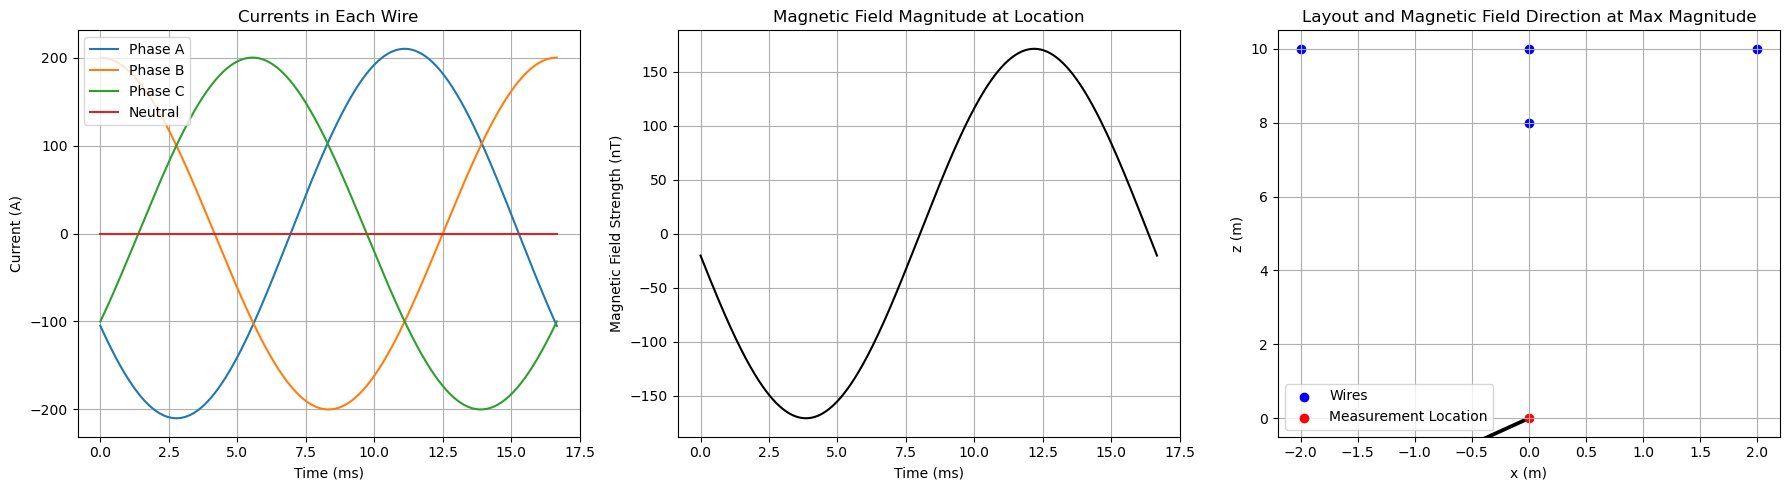

Bx_max: -1.5859887489975524e-07 Bz_max: -1.3584329929456645e-06


In [11]:
mu_0 = 4 * np.pi * 1e-7  # (T·m/A)
frequency = 60 

def calculate_magnetic_field_time_series(x_wires, z_wires, currents, phases, measurement_location, times):
    x_meas, y_meas = measurement_location
    Bx_total = np.zeros(len(times))
    Bz_total = np.zeros(len(times))
    B_total = np.zeros(len(times))
    I = np.zeros((len(x_wires), len(times)))
    
    for it, t in enumerate(times):
        for i, (x, z, current, phi) in enumerate(zip(x_wires, z_wires, currents, phases)):
            I_t = current * np.cos(2 * np.pi * frequency * t + phi)
            I[i, it] = I_t
            
            dx = x_meas - x
            dz = y_meas - z
            distance = np.sqrt(dx**2 + dz**2)

            if distance > 0:
                Bi = (mu_0 * I_t) / (2 * np.pi * distance)
                Bxi = -Bi * (dz / distance)
                Bzi = Bi * (dx / distance)
                Bx_total[it] += Bxi
                Bz_total[it] += Bzi
                B_total[it] += Bi
    
    return B_total, Bx_total, Bz_total, I

x_wires = [-2, 0, 2, 0]
z_wires = [10, 10, 10, 8]
currents = [210, 200, 200, 0]
phases = [2 * np.pi / 3, 0, -2 * np.pi / 3, 0]
measurement_location = (0, 0)
time_period = 1 / frequency
times = np.linspace(0, time_period, 1000)

B_total, Bx_total, Bz_total, I = calculate_magnetic_field_time_series(
    x_wires, z_wires, currents, phases, measurement_location, times
)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, label in enumerate(['Phase A', 'Phase B', 'Phase C', 'Neutral']):
    axs[0].plot(times * 1e3, I[i], label=label)
axs[0].set_title("Currents in Each Wire")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Current (A)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(times * 1e3, B_total * 1e9, color='black')
axs[1].set_title("Magnetic Field Magnitude at Location")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Magnetic Field Strength (nT)")
axs[1].grid(True)

max_index = np.argmax(np.abs(B_total))
Bx_max = Bx_total[max_index]
Bz_max = Bz_total[max_index]
Bx_max_unit = Bx_max / np.sqrt(Bx_max**2 + Bx_max**2)
Bz_max_unit = Bz_max / np.sqrt(Bx_max**2 + Bz_max**2)
axs[2].quiver(measurement_location[0], measurement_location[1], Bx_max_unit, Bz_max_unit, angles='xy', scale_units='xy', scale=1, color='black')
axs[2].scatter(x_wires, z_wires, color='blue', label='Wires')
axs[2].scatter(*measurement_location, color='red', label='Measurement Location')
axs[2].set_title("Layout and Magnetic Field Direction at Max Magnitude")
axs[2].set_xlabel("x (m)")
axs[2].set_ylabel("z (m)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print("Bx_max:", Bx_max, "Bz_max:", Bz_max)


# Noise Density as specified in DRV425 datasheet

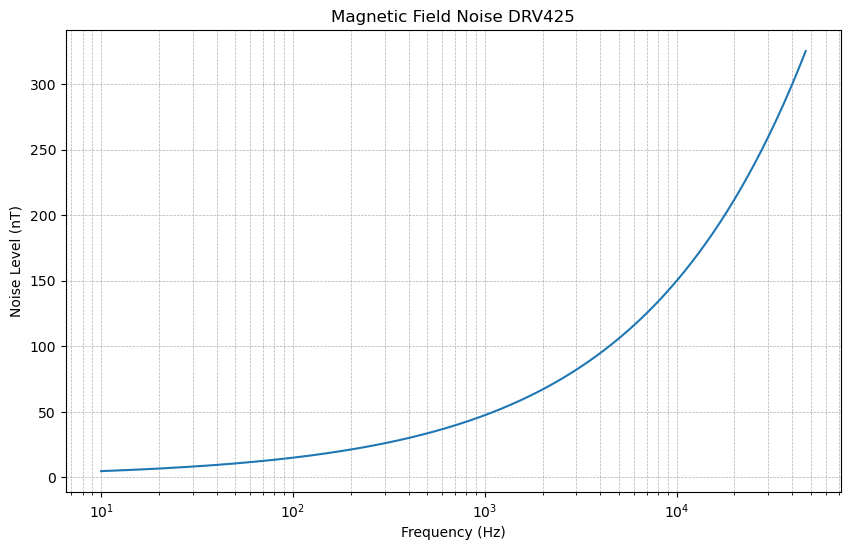

In [4]:

# Constants
noise_density = 1.5  #  nT/rootHz (from datasheet)
default_bandwidth = 47e3  # Default bandwidth

frequencies = np.logspace(1, np.log10(default_bandwidth), 500) 
noise_spectrum = noise_density * np.sqrt(frequencies) 

# Plot noise levels
plt.figure(figsize=(10, 6))
plt.plot(frequencies,noise_spectrum)
plt.xscale("log")
plt.title("Magnetic Field Noise DRV425")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noise Level (nT)")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

# Filter design

The transfer function $ H(f) $ for an RC low-pass filter:

$
H(f) = \frac{V_{\text{out}}(f)}{V_{\text{in}}(f)} = \frac{1}{1 + j \frac{f}{f_c}}
$


$
H(f) = \frac{1}{1 + j 2 \pi f R C}
$

$
|H(f)| = \frac{1}{\sqrt{1 + (2 \pi f R C)^2}}
$

the cutoff frequency:

$ f_c = \frac{1}{2 \pi R C}$

where

$|H(f_c)| = \frac{1}{\sqrt{2}} \approx 0.707$

Cutoff frequency (fc) for R = 1000.0 ohms and C = 1.50e+05 pF is 1061.03 Hz


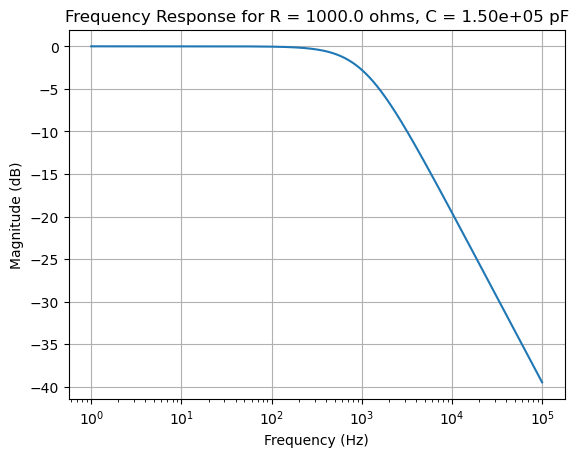

Resistance (R) for fc = 900 Hz and C = 1.50e+05 pF is 1178.93 ohms


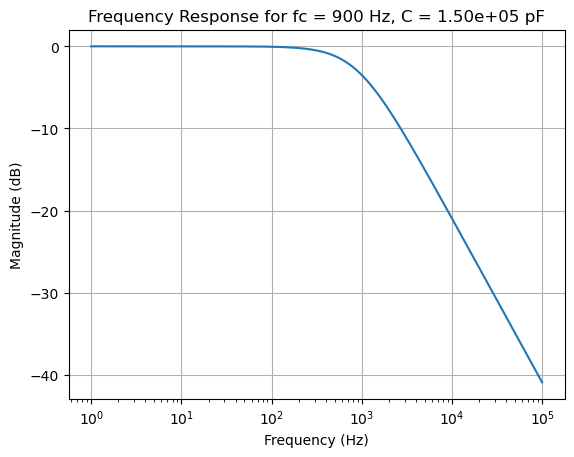

Capacitance (C) for fc = 900 Hz and R = 10000.0 ohms is 1.77e+04 pF


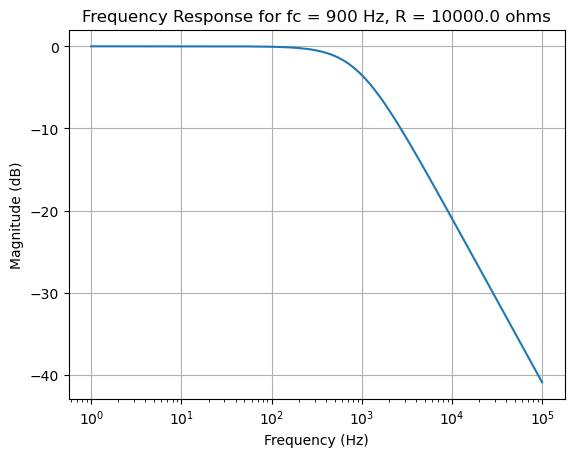

In [5]:
def calculate_cutoff_frequency(R, C_pF):
    """Calculate the cutoff frequency given R and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    fc = 1 / (2 * np.pi * R * C)
    return fc

def calculate_resistance(fc, C_pF):
    """Calculate the resistance R given fc and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    R = 1 / (2 * np.pi * fc * C)
    return R

def calculate_capacitance(fc, R):
    """Calculate the capacitance C in pF given fc and R."""
    C = 1 / (2 * np.pi * fc * R)
    C_pF = C * 1e12  # Convert F to pF
    return C_pF

def plot_frequency_response(R, C_pF, title):
    """Plot the frequency response for a given R and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    frequencies = np.logspace(0, 5, 500)  # Frequency range from 1 Hz to 100 kHz
    response = 1 / np.sqrt(1 + (2 * np.pi * frequencies * R * C) ** 2)
    plt.figure()
    plt.semilogx(frequencies, 20 * np.log10(response))  # Plot in dB
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.show()

#1: Calculate cutoff frequency
R = 1e3  # Ohms
C_pF = 15e4  # pF
fc = calculate_cutoff_frequency(R, C_pF)
print(f"Cutoff frequency (fc) for R = {R} ohms and C = {C_pF:.2e} pF is {fc:.2f} Hz")
plot_frequency_response(R, C_pF, f"Frequency Response for R = {R} ohms, C = {C_pF:.2e} pF")

#2: Calculate resistance
fc = 180 * 5  # Hz
C_pF = 15e4  # pF
R = calculate_resistance(fc, C_pF)
print(f"Resistance (R) for fc = {fc} Hz and C = {C_pF:.2e} pF is {R:.2f} ohms")
plot_frequency_response(R, C_pF, f"Frequency Response for fc = {fc} Hz, C = {C_pF:.2e} pF")

#3: Calculate capacitance
fc = 180 * 5  # Hz    
R = 10e3  # Ohms
C_pF = calculate_capacitance(fc, R)
print(f"Capacitance (C) for fc = {fc} Hz and R = {R} ohms is {C_pF:.2e} pF")
plot_frequency_response(R, C_pF, f"Frequency Response for fc = {fc} Hz, R = {R} ohms")


In [6]:
#single butterworth

k1 = 0.1592
k2 = 0.586

fc = 660 # Hz  
C = 10e-6
print(C)

R = k1/(C*fc)
print(R)

R1 = 1e3
Rf = R1 * k2
print(Rf)

1e-05
24.12121212121212
586.0


In [7]:
# dobule butterworth

k1 = 0.1592
k21 = 0.152
k22 = 1.235

fc = 660 # Hz  
C = 10e4 * 1e-12
print(C)

R = k1/(C*fc)
print(R)

R1 = 10e3
Rf1 = R1 * k21
print(Rf1)

Rf2 = R1 * k22
print(Rf2)

1e-07
2412.1212121212125
1520.0
12350.000000000002
